# Vertex Pipelines: Deploy custom model pipelines using google-cloud-pipeline-components


## Overview


This notebook shows how to use the components defined in [`google_cloud_pipeline_components`](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) to build an custom model workflow on [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines).

### Objective

In this example, you'll learn how to use components from `google_cloud_pipeline_components` to:
- create a _Dataset_ using data in cloud storage
- train an Custom AI model
- deploy the trained model to an _endpoint_ for serving

The components are [documented here](https://google-cloud-pipeline-components.readthedocs.io/en/latest/google_cloud_pipeline_components.aiplatform.html#module-google_cloud_pipeline_components.aiplatform).

In addition, you'll use the `kfp.v2.google.experimental.run_as_aiplatform_custom_job` method to train a custom model.

The components are [documented here](https://google-cloud-pipeline-components.readthedocs.io/en/latest/google_cloud_pipeline_components.aiplatform.html#module-google_cloud_pipeline_components.aiplatform).
(From that page, see also the `CustomPythonPackageTrainingJobRunOp` and `CustomContainerTrainingJobRunOp` components, which similarly run 'custom' training, but as with the related `google.cloud.aiplatform.CustomContainerTrainingJob` and `google.cloud.aiplatform.CustomPythonPackageTrainingJob` methods from the [Vertex AI SDK](https://googleapis.dev/python/aiplatform/latest/aiplatform.html), also upload the trained model).

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI Training and Serving
* Cloud Storage
* BigQuery Table


### Set up your  development environment

**Please note that the environment for the following notebook steps can be run on Google Cloud Notebooks**, your environment already meets
all the requirements to run this notebook.

## Before you begin

This notebook does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Cloud Storage, and Compute Engine APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,storage-component.googleapis.com). 

1. Follow the "**Configuring your project**" instructions from the Vertex Pipelines documentation.

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Install additional packages


In [3]:
!pip3 install -q google-cloud-aiplatform
!pip3 install -q kfp google-cloud-pipeline-components

In [4]:
!pip3 install -q google-cloud-storage==1.32.0


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [5]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Check the versions of the packages you installed.  The KFP SDK version should be >=1.6.

In [2]:
#test the version of Kfp - should be >= 1.6

import kfp
print('KFP SDK version: {}'.format(kfp.__version__))

KFP SDK version: 1.6.2


In [36]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)


Project ID:  tech-fault-demo


Otherwise, set your project ID here.

In [4]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "<CHANGE_THIS>"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**Ensure that you are using Google Cloud Notebooks**, where your environment is already
authenticated. 

### Create a Cloud Storage bucket as necessary

You will need a Cloud Storage bucket for this example.  If you don't have one that you want to use, you can make one now.


Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [18]:
#BUCKET_NAME = "gs://project849089-bucket/vai"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "gs://" + PROJECT_ID + "_vertexai_" + TIMESTAMP

print(BUCKET_NAME)

gs://tech-fault-demo_vertexai_20210601231210


In [19]:
! gsutil mb -l $REGION $BUCKET_NAME

Creating gs://tech-fault-demo_vertexai_20210601231210/...


Finally, validate access to your Cloud Storage bucket by examining its contents. You should 2 files, one each for train and test being copied.

In [20]:
!gsutil -m cp -r gs://aju-dev-demos-codelabs/bikes_weather/train-bw000000000000.csv $BUCKET_NAME/bikes_weather/train-bw000000000000.csv
!gsutil -m cp -r gs://aju-dev-demos-codelabs/bikes_weather/test-bw000000000009.csv $BUCKET_NAME/bikes_weather/test-bw000000000009.csv        

Copying gs://aju-dev-demos-codelabs/bikes_weather/train-bw000000000000.csv [Content-Type=application/octet-stream]...
- [1/1 files][335.9 MiB/335.9 MiB] 100% Done                                    
Operation completed over 1 objects/335.9 MiB.                                    
Copying gs://aju-dev-demos-codelabs/bikes_weather/test-bw000000000009.csv [Content-Type=application/octet-stream]...
- [1/1 files][336.5 MiB/336.5 MiB] 100% Done                                    
Operation completed over 1 objects/336.5 MiB.                                    


In [21]:
! gsutil ls -al $BUCKET_NAME/bikes_weather

 352877721  2021-06-01T23:23:08Z  gs://tech-fault-demo_vertexai_20210601231210/bikes_weather/test-bw000000000009.csv#1622589788124882  metageneration=1
 352185296  2021-06-01T23:22:57Z  gs://tech-fault-demo_vertexai_20210601231210/bikes_weather/train-bw000000000000.csv#1622589777017902  metageneration=1
TOTAL: 2 objects, 705063017 bytes (672.4 MiB)


**Setting up Service Account**

Refer to the step#2 and #3 of the Qwiklabs.

**Excerpt from the Qwiklab:**

Once the Vertex AI API is enabled, you will be taken to the Vertex-AI API properties page. Alternatively, you can click on the “Manage” button to reach here.


From the left side of the screen, click on “Credentials” and make a note of the service account of the compute service account. This service account will be used to grant access to the bucket from the Vertex AI notebooks in the next few steps.
For e.g. It will look something like this
"1023279203633-compute@developer.gserviceaccount.com"

In [37]:
# you can get this from the Vertex AI API Credentials page, it will be something like this [account]-compute@developer.gserviceaccount.com 
#for e.g. service_account = '1023279203633-compute@developer.gserviceaccount.com'

service_account = '<Replace with Service account for the Vertex AI API>'  # <<- Please change this


In [41]:
!gsutil iam ch serviceAccount:$service_account:roles/storage.admin $BUCKET_NAME

### Import libraries and define constants

Define some constants. 


In [43]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

USER = "custom_ml"  # <---CHANGE THIS
PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)

PIPELINE_ROOT

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin


'gs://tech-fault-demo_vertexai_20210601231210/pipeline_root/custom_ml'

## Define a custom model classification pipeline that uses components from google_cloud_pipeline_components

Do some imports:

In [44]:
import uuid

import kfp
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import compiler
from kfp.v2.google.client import AIPlatformClient
from kfp.v2 import compiler
from kfp.v2.dsl import component
from kfp.v2.google import experimental
from kfp.v2.google.client import AIPlatformClient

project=PROJECT_ID


Use the dataset from your bucket and train it using custom model Training.


Define the pipeline:

Pipeline module consists of 3 tasks / operations: 

1- **Create dataset task:** A dataset with the display name will be created under the dataset options in Vertex AI Screen

2- **Create training run task:** A Tabular Training Job is defined, with the dataset, prediction_type, optimization objectives and the target_column. 

3- **Model deploy task:** Model deployment task with project name and machine_type. Please note that the parameter machine_type is mandatory.

Set some variables that will be used in constructing the args passed to the custom training job and setting pipeline params.

In [45]:
# create args list for trainer

hp_dict: str = '{"num_hidden_layers": 3, "hidden_size": 16, "learning_rate": 0.5, "epochs": 1, "steps_per_epoch": 5}'
data_dir: str = BUCKET_NAME+"/bikes_weather/"
TRAINER_ARGS = ["--data-dir", data_dir, "--hptune-dict", hp_dict]

# create working dir to pass to job spec
import time

ts = int(time.time())
WORKING_DIR = f"{PIPELINE_ROOT}/{ts}"

MODEL_DISPLAY_NAME = f"custom_model_deploy{ts}"
print(TRAINER_ARGS, WORKING_DIR, MODEL_DISPLAY_NAME)

['--data-dir', 'gs://tech-fault-demo_vertexai_20210601231210/bikes_weather/', '--hptune-dict', '{"num_hidden_layers": 3, "hidden_size": 16, "learning_rate": 0.5, "epochs": 1, "steps_per_epoch": 5}'] gs://tech-fault-demo_vertexai_20210601231210/pipeline_root/custom_ml/1622594038 custom_model_deploy1622594038


Set some variables that will be used in constructing the args passed to the custom training job and setting pipeline params.

Next, you define a component with which the custom training job is run.  For this example, this component doesn't do anything (but run a print statement).

In [46]:
@component
def training_op(input1: str):
    print("training task: {}".format(input1))

Now, you define the pipeline.  

The `experimental.run_as_aiplatform_custom_job` method takes as args the component defined above, and the list of `worker_pool_specs`— in this case  one— with which the custom training job is configured. 

Then, [`google_cloud_pipeline_components`](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) components are used to define the rest of the pipeline: upload the model, create an endpoint, and deploy the model to the endpoint. (While not shown in this example, the model deploy will create an endpoint if one is not provided.)

In [47]:
@kfp.dsl.pipeline(name="train-custom-model" + str(uuid.uuid4()))
def pipeline(
    project: str = PROJECT_ID,
    model_display_name: str = MODEL_DISPLAY_NAME,
    serving_container_image_uri: str = "us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-3:latest",
):

    train_task = training_op("model training")
    experimental.run_as_aiplatform_custom_job(
        train_task,
        worker_pool_specs=[
            {
                "containerSpec": {
                    "args": TRAINER_ARGS,
                    "env": [{"name": "AIP_MODEL_DIR", "value": WORKING_DIR}],
                    "imageUri": "gcr.io/google-samples/bw-cc-train:latest",
                },
                "replicaCount": "1",
                "machineSpec": {
                    "machineType": "n1-standard-16",
                    "accelerator_type": aiplatform.gapic.AcceleratorType.NVIDIA_TESLA_K80,
                    "accelerator_count": 2,
                },
            }
        ],
    )

    model_upload_op = gcc_aip.ModelUploadOp(
        project=project,
        display_name=model_display_name,
        artifact_uri=WORKING_DIR,
        serving_container_image_uri=serving_container_image_uri,
        serving_container_environment_variables={"NOT_USED": "NO_VALUE"},
    )
    model_upload_op.after(train_task)

    endpoint_create_op = gcc_aip.EndpointCreateOp(
        project=project,
        display_name="pipelines-created-endpoint",
    )

    model_deploy_op = gcc_aip.ModelDeployOp(  # noqa: F841
        project=project,
        endpoint=endpoint_create_op.outputs["endpoint"],
        model=model_upload_op.outputs["model"],
        deployed_model_display_name=model_display_name,
        machine_type="n1-standard-4",
    )

## Compile and run the pipeline

Now, you're ready to compile the pipeline:

In [48]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="train_custom_model.json"
)

The pipeline compilation generates the `train_upload_deploy.json` job spec file.

Next, instantiate an API client object:

In [49]:
from kfp.v2.google.client import AIPlatformClient  # noqa: F811

api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

Then, you run the defined pipeline like this: 

In [50]:
response = api_client.create_run_from_job_spec(
    "train_custom_model.json",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"project": PROJECT_ID},
)

Click on the generated link to see your run in the Cloud Console.  It should look something like this:

You can also try clicking on the "Expanded Artifacts" toggle button on the top. 

<a href="https://storage.googleapis.com/amy-jo/images/mp/train_endpoint_deploy.png" target="_blank"><img src="https://storage.googleapis.com/amy-jo/images/mp/train_endpoint_deploy.png" width="75%"/></a>


## Observe

Observe the corresponding entries in the pipeline and models section from the Vertex AI interface.



In this example, you learnt how to use components from `google_cloud_pipeline_components` to:

- create a _Dataset_ using data in cloud storage
- train an Custom AI model
- deploy the trained model to an _endpoint_ for serving


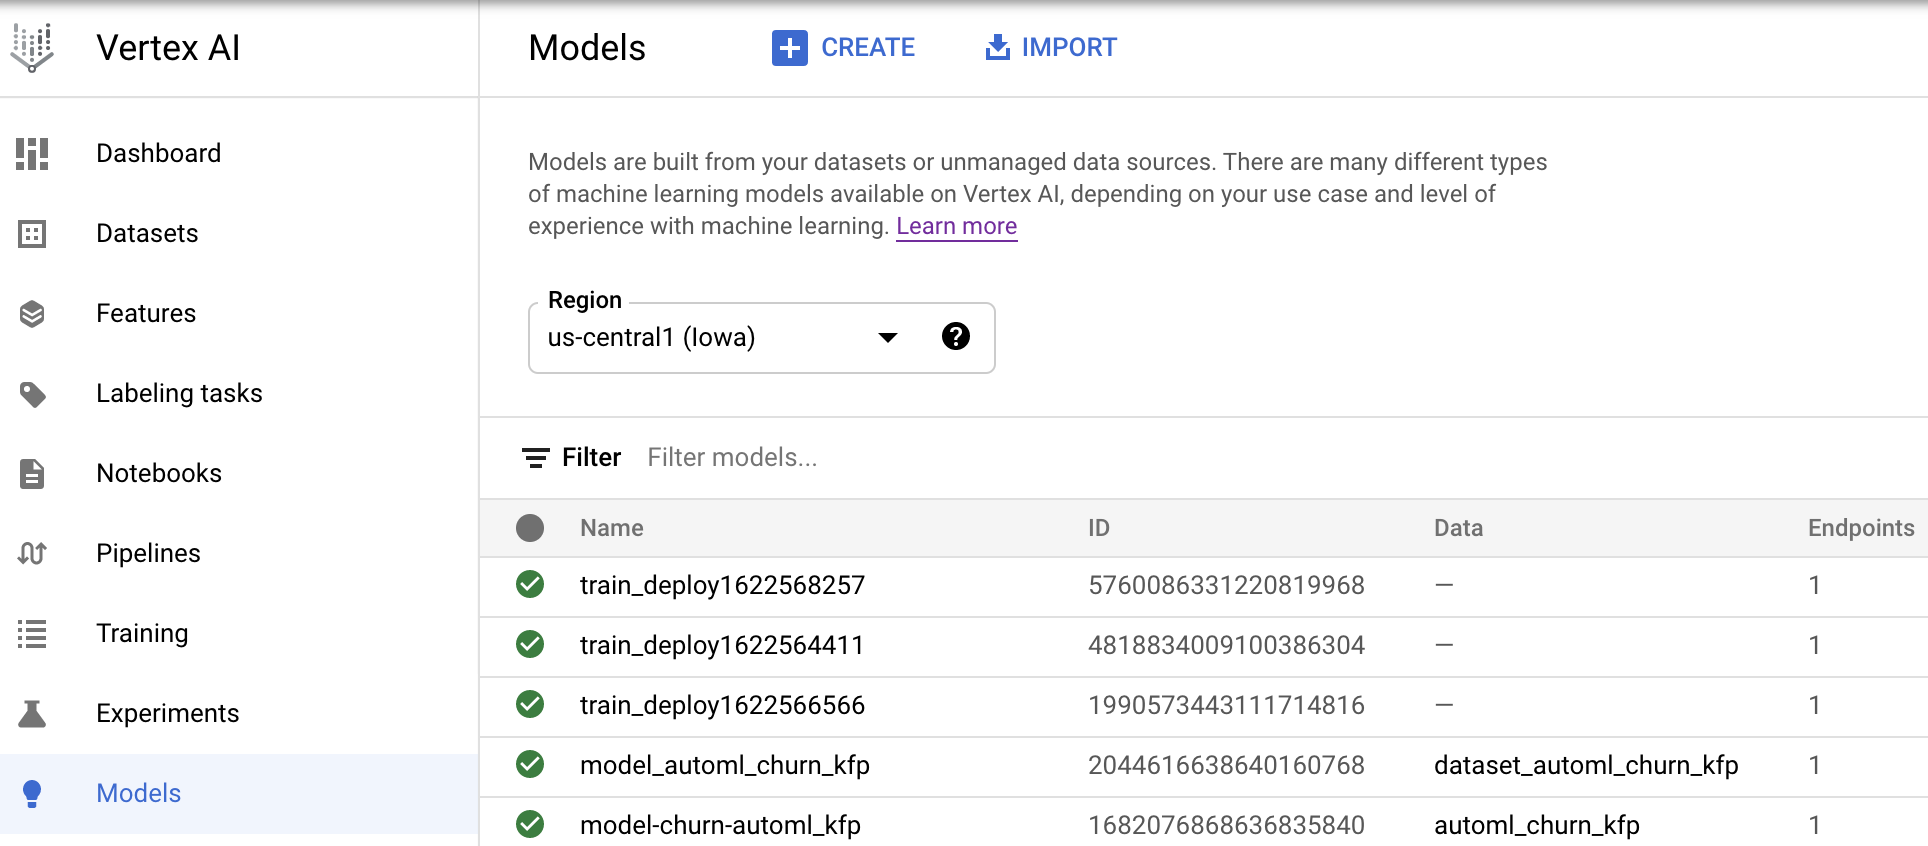

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:
- Delete Cloud Storage objects that were created.  Uncomment and run the command in the cell below **only if you are not using the `PIPELINE_ROOT` path for any other purpose**.
- Delete your deployed model: first, undeploy it from its *endpoint*, then delete the model and endpoint.


In [ ]:
# Warning: this command will delete ALL Cloud Storage objects under the PIPELINE_ROOT path.
# ! gsutil -m rm -r $PIPELINE_ROOT

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.